# Modelling tabular data with diffusion models

This tutorial demonstrates hot to use a denoising diffusion probabilistic model (DDPM) to synthesize tabular data. The algorithm was proposed in [TabDDPM: Modelling Tabular Data with Diffusion Models](https://arxiv.org/abs/2209.15421).

In [ ]:
!pip install synthcity

In [1]:
# stdlib
import sys
import warnings

# third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
# from sklearn.datasets import load_iris, load_diabetes

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.metrics import eval_statistical

log.add(sink=sys.stderr, level="INFO")
warnings.filterwarnings("ignore")

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


## Synthesize a classification dataset

For classification datasets, TabDDPM automatically uses the labels as the conditional variable during training. You should not provide an additional `cond` argument to the `fit` method.

In [38]:
data = pd.read_csv("/content/df_train_CM-100.csv")
X = data.drop("label", axis = 1)
y = data["label"]

In [39]:
# Note: preprocessing data with OneHotEncoder or StandardScaler is not needed or recommended. Synthcity handles feature encoding and standardization internally.
loader = GenericDataLoader(data, target_column="label", sensitive_columns=[])

loader.dataframe().head()

,12ppd__R,12ppd__S,13ppd,14glucan,15dap,23camp,23ccmp,23cgmp,23cump,23dappa,...,xtsn,xyl3,xyl__D,xylan12,xylan4,xylan8,xylb,xylu__L,zn2,label
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,0,0,0,1,0,1,1,1,0,0,...,0,1,1,0,0,0,0,0,1,0
2,0,1,0,0,0,0,1,1,1,0,...,0,0,1,0,0,0,0,0,1,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,1,1


### Model fitting

In [ ]:
# define the model hyper-parameters
plugin_params = dict(
    is_classification = True,
    n_iter = 1000,  # epochs
    lr = 0.00006,
    weight_decay = 1e-6,
    batch_size = 100,
    model_type = "mlp",  # or "resnet"
    model_params = dict(
        n_layers_hidden = 3,
        n_units_hidden = 256,
        dropout = 0.3,
    ),
    num_timesteps = 500,  # timesteps in diffusion
    dim_embed = 128,
    log_interval = 10,
    # print_interval = 100,
)

plugin = Plugins().get("ctgan", **plugin_params)
plugin.fit(loader)

<Axes: xlabel='step'>

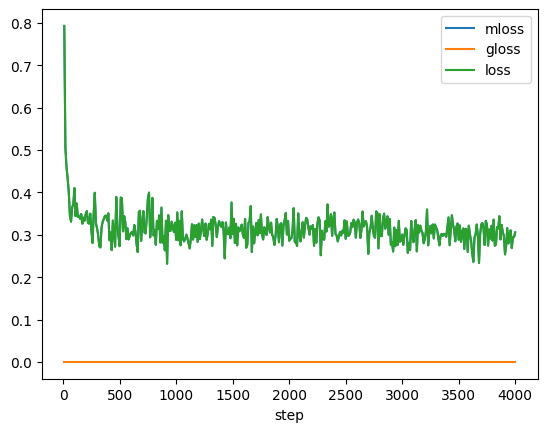

In [ ]:
# plot training curves
plugin.loss_history.plot()

### Data generation

Since the model training is conditional to the labels, the data generation requires the labels as well. You can pass the labels as a `cond` argument to the `generate` method. If it is not provided, the model will randomly generate the labels following the multinomial distribution of the training labels.

In [30]:
plugin.generate(10)

,12ppd__R,12ppd__S,13ppd,14glucan,15dap,23camp,23ccmp,23cgmp,23cump,23dappa,...,xtsn,xyl3,xyl__D,xylan12,xylan4,xylan8,xylb,xylu__L,zn2,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
9,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,1,0,1,0


In [43]:
test = pd.read_csv("/content/df_test_CM-100.csv")

In [44]:
syn = plugin.generate(test.shape[0])

### Conditional data generation

In [ ]:
# labels = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])
# plugin.generate(len(labels), cond=labels)

#Metrics

In [45]:
X_syn_loader = syn
X_real_loader = GenericDataLoader(test)

In [ ]:
X_syn_loader.dataframe().shape

In [ ]:
X_real_loader

In [36]:
quality_eval = eval_statistical.AlphaPrecision()
qual_res = quality_eval.evaluate(X_real_loader, X_syn_loader)
qual_res = {
    k: v for (k, v) in qual_res.items() if "naive" in k
}  # use the naive implementation of AlphaPrecision
qual_score = np.mean(list(qual_res.values()))

print('alpha precision: {:.6f}, beta recall: {:.6f}'.format(qual_res['delta_precision_alpha_naive'], qual_res['delta_coverage_beta_naive'] ))

Alpha_Precision_all = qual_res['delta_precision_alpha_naive']
Beta_Recall_all = qual_res['delta_coverage_beta_naive']

alpha precision: 0.546737, beta recall: 0.985391


In [48]:
real = X_real_loader.dataframe().values
fake = X_syn_loader.dataframe().values

DISTANCE = "hamming"

def diversity(D, metric="hamming"):
    n = len(D)
    dist_matrix = cdist(D, D, metric=metric)
    np.fill_diagonal(dist_matrix, 0)
    total = dist_matrix.sum()
    return total / (n * (n - 1))

def novelty(D_gen, D_real, metric="hamming"):
    dist_matrix = cdist(D_gen, D_real, metric=metric)
    return np.mean(np.min(dist_matrix, axis=1))

# Compute metrics
div_score = diversity(fake, metric=DISTANCE)
nov_score = novelty(fake, real, metric=DISTANCE)

print(f"Diversity = {div_score:.4f}")
print(f"Novelty   = {nov_score:.4f}")

Diversity = 0.1618
Novelty   = 0.1812
